# Alignment and annotation of adult mouse brain slices with STalign

First of all, import all the dependencies that are needed for the notebook to work.

Some dependencies that might be less easy to import are the ones related to brainmap and STalign (last two lines). In particular:
 - brainmap: go to https://github.com/linnarsson-lab/brainmap/tree/master and download the 'brainmap' folder; then, insert the brainmap folder inside the same folder of this notebook you are working with;
 
 - STalign: go to https://github.com/JEFworks-Lab/STalign and follow the instructions inside the README; otherwise, simply run:
 
                            pip install --upgrade "git+https://github.com/JEFworks-Lab/STalign.git"
    from terminal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import tifffile
from PIL import Image
from scipy.ndimage import rotate
from brainmap import AllenBrainReference, AllenBrainStructure, AllenVolumetricData
from STalign import STalign
import cv2
from skimage.measure import find_contours

If you are working within e shared workstation, you may need to limit your use of resources. To this end, use the following cell to set the so called 'threadpool_limits', depending on the available/needed threads.

In [2]:
from threadpoolctl import threadpool_limits
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
os.environ["OMP_NUM_THREADS"] = "10"
threadpool_limits(10)

## Load the ome.tif image

Set once and for all the path to your image

In [3]:
# Open the OME-TIFF file
tif_path = 'Images/morphology_mip_23931A.ome.tif'
tif_image = tifffile.imread(tif_path)

# Now you have the image as a numpy array, you can manipulate it as needed
print(tif_image.shape)

# Flatten the image
tif_image.flatten()

# Extract the two dimensions
x_dim, y_dim = tif_image.shape

# Finally convert your image into a dataframe
df = pd.DataFrame(tif_image)
print(df)

(51128, 42676)
       0      1      2      3      4      5      6      7      8      9      \
0          0      0      0      0      0      0      0      0      0      0   
1          0      0      0      0      0      0      0      0      0      0   
2          0      0      0      0      0      0      0      0      0      0   
3          0      0      0      0      0      0      0      0      0      0   
4          0      0      0      0      0      0      0      0      0      0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
51123      0      0      0      0      0      0      0      0      0      0   
51124      0      0      0      0      0      0      0      0      0      0   
51125      0      0      0      0      0      0      0      0      0      0   
51126      0      0      0      0      0      0      0      0      0      0   
51127      0      0      0      0      0      0      0      0      0      0   

       ...  42666  42667  42668  426

Downsample the image: since the image has a huge dimension, you may want to downsample it for computational efficiency purposes

In [4]:
# Downsample function
def hard_downsample(image_path, factor):
    img = tifffile.imread(image_path)
    img = Image.fromarray(img)
    new_width = img.width // factor
    new_height = img.height // factor
    img_resized = img.resize((new_width, new_height), resample=Image.NEAREST)

    # Save the downsized image - pay attention to set the path you prefer!
    img_resized.save("downsampled_image.tif")

# Downsampling
image_path = tif_path
downsampling_factor = 10  # Adjust this according to your needs
hard_downsample(image_path, downsampling_factor)

And now, do the same things as above for the downsampled image...

In [5]:
tif_path = 'downsampled_image.tif'
tif_image = tifffile.imread(tif_path)
print(tif_image.shape) # -> decreased size, more convenient

(5112, 4267)


Plot the image points if needed, it is right not to see barely anything, just some shapes. It may not be so useful

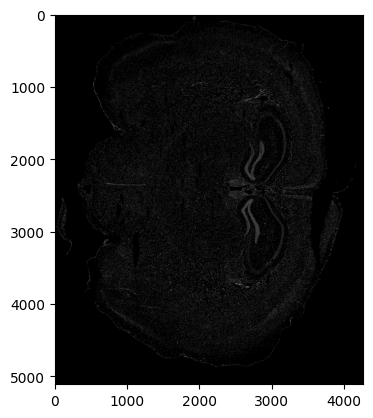

In [6]:
plt.imshow(tif_image, cmap='gray', vmax = tif_image.max(), vmin = tif_image.min())

In [7]:
# Extract the two dimensions
height, width = tif_image.shape[:2]

# Arrays with x,y coordinates
x_coords, y_coords = np.meshgrid(range(width), range(height))

x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
values_flat = tif_image.flatten()

# Finally convert your image into a dataframe...
df = pd.DataFrame({
    'x': x_flat,
    'y': y_flat,
    'value': values_flat
})

# ... and keep only the points giving us information, so the ones with value different from 0
df = df[df['value'] != 0]
print(df)

             x     y  value
3412      3412     0      1
3417      3417     0      1
3422      3422     0      1
3425      3425     0      1
3432      3432     0      1
...        ...   ...    ...
21809926  1289  5111      1
21809936  1299  5111      1
21809939  1302  5111      1
21809945  1308  5111      1
21810010  1373  5111      1

[18549827 rows x 3 columns]


In [8]:
# You may still have a lot of points, so you can keep just the 'more important' ones, that is, the ones
# with a value above the mean
mean_value = df['value'].mean()

selected_df = df[df['value'] > mean_value]

print(selected_df)

             x     y  value
121395    1919    28    368
121396    1920    28    383
121397    1921    28    437
121398    1922    28    426
121399    1923    28    401
...        ...   ...    ...
21105842  1260  4946    442
21105843  1261  4946    312
21110108  1259  4947    406
21110109  1260  4947    321
21114375  1259  4948    387

[4843095 rows x 3 columns]


## Start the STalign procedure

First of all, create two arrays with x,y coordinates. x and y are inverted in the usual ome_tif images. We double the coordinates to make them the most similar possible to the one of the Allen atlas.

In [9]:
yI = np.array(selected_df['x'])
xI = np.array(selected_df['y'])

0 of 4843095
10000 of 4843095
20000 of 4843095
30000 of 4843095
40000 of 4843095
50000 of 4843095
60000 of 4843095
70000 of 4843095
80000 of 4843095
90000 of 4843095
100000 of 4843095
110000 of 4843095
120000 of 4843095
130000 of 4843095
140000 of 4843095
150000 of 4843095
160000 of 4843095
170000 of 4843095
180000 of 4843095
190000 of 4843095
200000 of 4843095
210000 of 4843095
220000 of 4843095
230000 of 4843095
240000 of 4843095
250000 of 4843095
260000 of 4843095
270000 of 4843095
280000 of 4843095
290000 of 4843095
300000 of 4843095
310000 of 4843095
320000 of 4843095
330000 of 4843095
340000 of 4843095
350000 of 4843095
360000 of 4843095
370000 of 4843095
380000 of 4843095
390000 of 4843095
400000 of 4843095
410000 of 4843095
420000 of 4843095
430000 of 4843095
440000 of 4843095
450000 of 4843095
460000 of 4843095
470000 of 4843095
480000 of 4843095
490000 of 4843095
500000 of 4843095
510000 of 4843095
520000 of 4843095
530000 of 4843095
540000 of 4843095
550000 of 4843095
560000

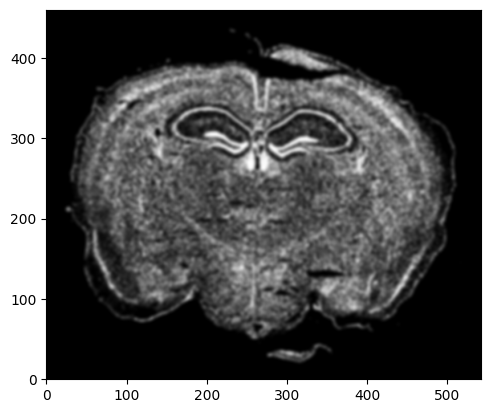

In [10]:
# rasterize at 10um resolution (assuming positions are in um units) and plot - this takes some time
X_,Y_,W,fig = STalign.rasterize(xI, yI, dx=10)

ax = fig.axes[0]
ax.invert_yaxis()
W = W[0]

# Load the following data from Linnarsson-lab's GitHub

In particular, at the link https://github.com/linnarsson-lab/brainmap you will find the folder 'data', in which you can find different 3D dataframes (data/AllenBrain3d). You may prefer to download the whole brainmap-master folder and access to it as below.

In [11]:
ABR = AllenBrainReference("adult")
annotation = AllenVolumetricData("../brainmap-master/data/AllenBrain3d/P56_Mouse_annotation.zip", reference=ABR)
grayscale = AllenVolumetricData("../brainmap-master/data/AllenBrain3d/P56_atlasVolume.zip", reference=ABR)
griddata = AllenVolumetricData("../brainmap-master/data/AllenBrain3d/P56_Mouse_gridAnnotation.zip", reference=ABR)

# Find the most similar slice among the ones in the loaded data

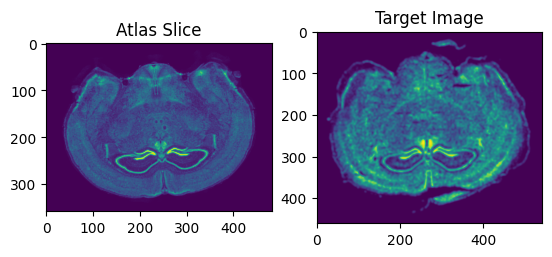

In [12]:
# Select a slice which you think can be the most similar to yours; check the plots below
# Your image will be rotated wrt the Allen one: find the correct theta_deg angle of rotation
slice = 275
theta_deg = 185

A = grayscale
L = annotation

dxA = np.array([50., 50., 50.])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')


fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg))#,extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W)#,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

# Optional: select some points to start the alignment

This may be useful but not too much honestly

In [13]:
# Select some points you wish would be aligned with a certain priority. a --> Atlas, t --> Target (your image)
# point1a = [0, 1500]
# point2a = [-6000, -6700]

# point1t = [500, 800]
# point2t = [-6900, -6500]

# fig,ax = plt.subplots(1,2)
# extentA = STalign.extent_from_x(xA[1:])
# ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
# ax[0].scatter(point1a[0], point1a[1], color='red',s=1)  
# ax[0].scatter(point2a[0], point2a[1], color='red',s=1) 
# ax[0].set_title('Atlas Slice')

# ax[1].imshow(W,extent=extentA)
# ax[1].scatter(point1t[0], punto1t[1], color='red',s=1)  
# ax[1].scatter(point2t[0], point2t[1], color='red',s=1)  
# ax[1].set_title('Target Image')
# fig.canvas.draw()

In [14]:
# Run this if you want to actually select some points
# points_atlas = np.array([point1a, point2a])
# points_target = np.array([point1t, point2t])
# Li,Ti = STalign.L_T_from_points(points_atlas,points_target)

In [15]:
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
A = A[:,:,:]
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

Initialize some parameters that will be passed to the main function. Usually it is fine to keep the following.

In [16]:
sigmaA = 2 #standard deviation of artifact intensities
sigmaB = 2 #standard deviation of background intensities
muA = torch.tensor([3,3,3],device='cpu') #average of artifact intensities
muB = torch.tensor([0,0,0],device='cpu') #average of background intensities

Text(0.5, 1.0, 'Intensity Histogram of Target Image')

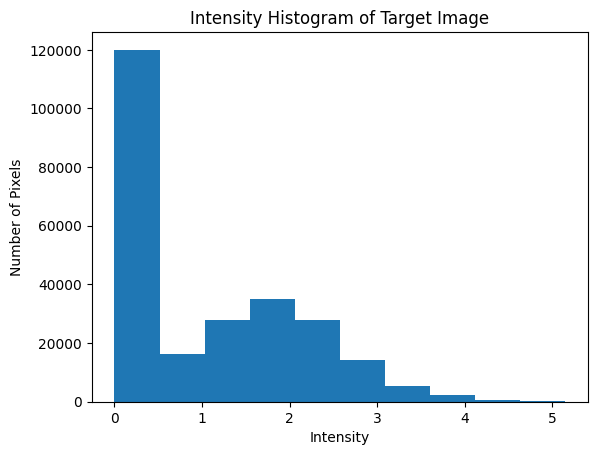

In [17]:
fig,ax = plt.subplots()
ax.hist(J.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

Initialize here some more variables. Pay attention!! It is fundamental to select the right scales (scale_x, scale_y, scale_z).
To this end, a suggestion: start running the 'LDDMM' cell below, setting niter = 1; then, check the result and compare the two images that you see plotted. Based on that output, you can fix the scale as you think it is better.

CPU times: user 13h 34min 23s, sys: 9h 11min 3s, total: 22h 45min 27s
Wall time: 3h 6min 47s


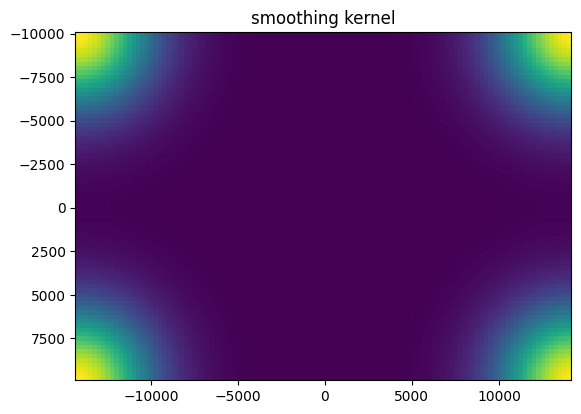

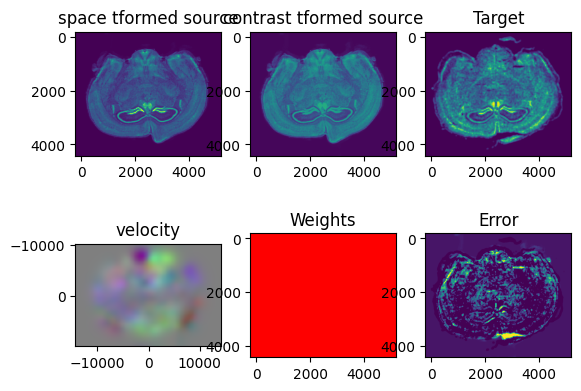

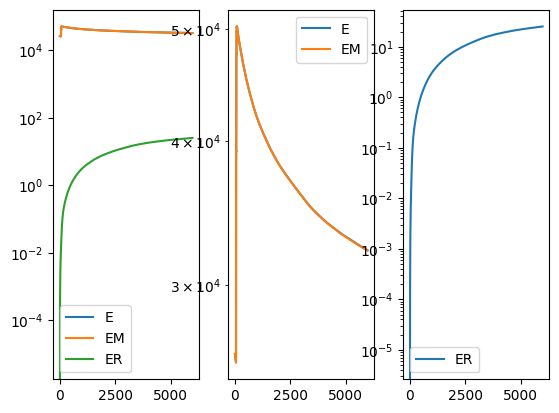

In [20]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:

    device = 'cpu'

# SCALES!
scale_x = 0.23 #default = 0.9
scale_y = 0.23 #default = 0.9
scale_z = 1 #default = 0.9

theta0 = (np.pi/180)*theta_deg

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas) #np.identity(3)

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=6000,
    device='cpu',
    sigmaA = 2, #standard deviation of artifact intensities
    sigmaB = 2, #standard deviation of background intensities
    sigmaM = 1, #standard deviation of matching tissue intenities
    sigmaR = 1e10,
    muA = muA, #average of artifact intensities
    muB = muB, #average of background intensities
    epL=1e-10,
    epT=5e-4,
    epV = 500,
    #a = 400,
)


## How to analyze the output
If the parmeters were set well, and the alignment at least tried to work, you should see the orange curve in the middle (representing the evolution of the matching error as the iterations grow) with a decreasing trend. In order for the alignment to reach the best possible result, the orange curve must have reached a plateau, so it should not be still decreasing in the last iterations. If it is:
- increase the number of niter;
- increase 'epV', which is the velocity gradient step.

If the orange curve is INCREASING, then you set the wrong parameters: start changing sigmaM of some orders of magnitude (0.1, then 1, then 10 and so on).

In [21]:
A = transform['A']
v = transform['v']
xv = transform['xv']
Xs = transform['Xs']

## Show the output
If the output is good, in the case of Adult Mouse Brain, you should see at least the hyppocampus superimposed quite perfectly.

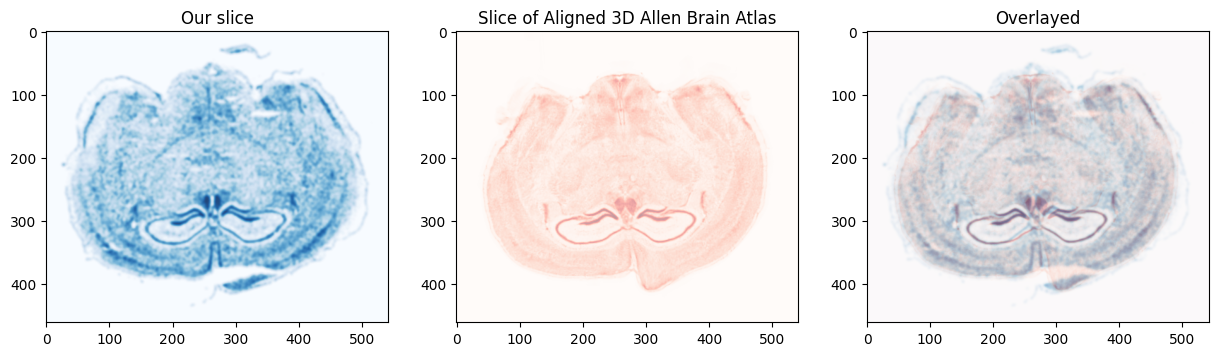

In [22]:
It = torch.tensor(I,device='cpu',dtype=torch.float64)
AI = STalign.interp3D(xI,It,Xs.permute(3,0,1,2),padding_mode="border")
Ishow_source = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
Jt = torch.tensor(J,device='cpu',dtype=torch.float64)
Ishow_target = Jt.permute(1,2,0).cpu()/torch.max(Jt).item()

import matplotlib as mpl
Ishow_target = Ishow_target.squeeze()
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax0 = ax[0].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax[0].set_title('Our slice')
ax1 = ax[1].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.4)
ax[1].set_title('Slice of Aligned 3D Allen Brain Atlas')
ax2 = ax[2].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.6)
ax2 = ax[2].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.3)
ax[2].set_title('Overlayed')

plt.show()

# Annotations

Here you will extract the annotations from the Allen data, superimpose them onto the original image and create a final dataframe that has, for each point of the original figure, the corresponding brain region associated both with the acronym and the name.

Text(0.5, 1.0, 'Annotations aligned')

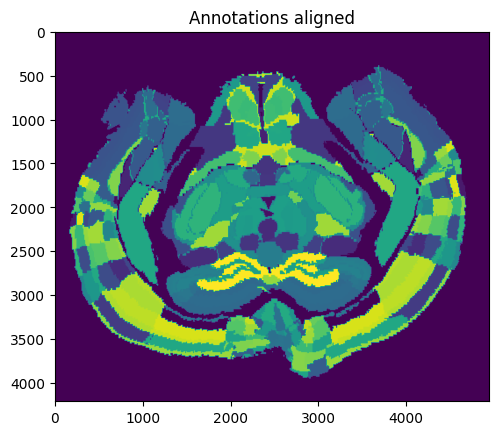

In [24]:
import cv2 

L = annotation
L = L[None]
annotation_aligned = STalign.interp3D(xI,L.astype(np.float64),Xs.permute(-1,0,1,2),mode='nearest')
img = annotation_aligned[0][0].numpy()

target_size = (int(max(X_)-min(X_)),int(max(Y_)-min(Y_)))
resized_img = cv2.resize(img, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

yI = np.array(selected_df['x'])
xI = np.array(selected_df['y'])

x = xI
y = yI
expand = 1.1
minx = np.min(x)
maxx = np.max(x)
miny = np.min(y)
maxy = np.max(y)
miny_img = ((expand-1)/2)*(maxy-miny)
maxy_img = (miny+maxy)/2.0 + (maxy-miny)/2.0*expand
minx_img = ((expand-1)/2)*(maxx-minx)
maxx_img = (minx+maxx)/2.0 + (maxx-minx)/2.0*expand

image_np = resized_img[int(miny_img):int(maxy_img), int(minx_img):int(maxx_img)]

fig,ax = plt.subplots(1,1)
ax.imshow(image_np)
ax.set_title('Annotations aligned')

Extract the boundaries of the contours

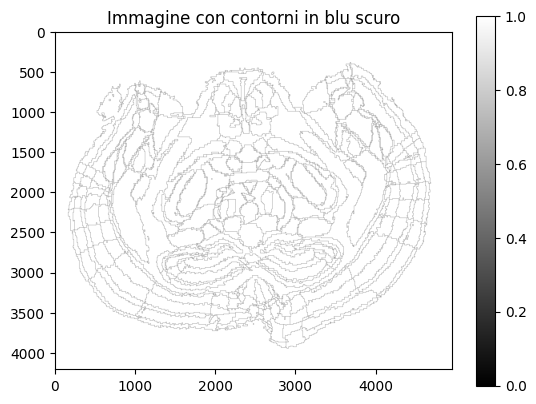

In [25]:
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(image_np, kernel, iterations=1)
dilation = cv2.dilate(image_np, kernel, iterations=1)
contours = dilation - erosion

merged_image = np.ones_like(image_np)
threshold = 0.5
merged_image[contours > threshold] = 0 

plt.imshow(merged_image, cmap='gray')
plt.title('Immagine con contorni in blu scuro')
plt.colorbar()  # Aggiungi una barra dei colori
plt.show()

And plot them over the original image

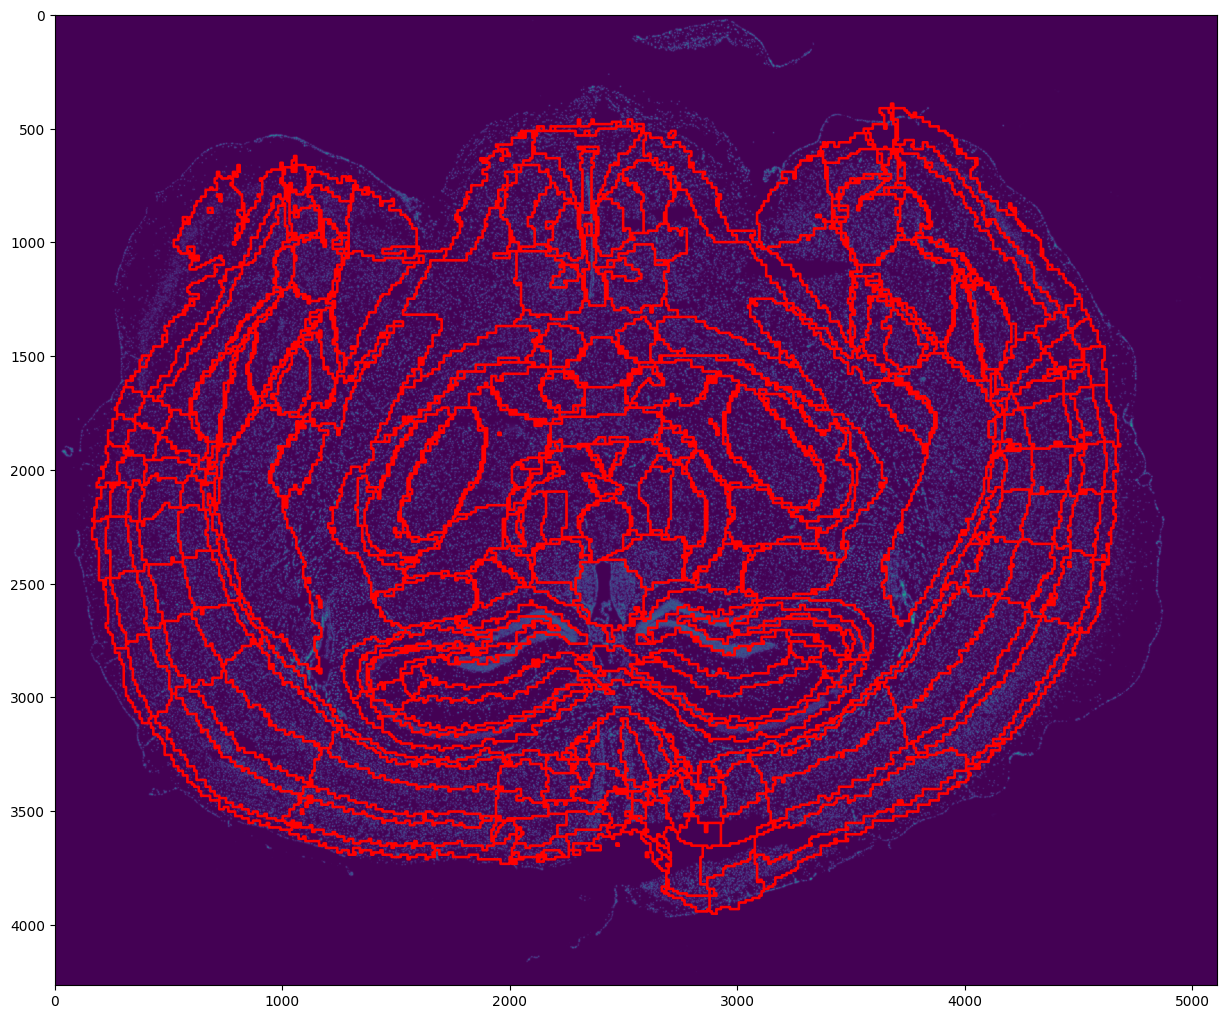

In [29]:
np.unique(merged_image)
contours = find_contours(merged_image)
plt.figure(figsize=(15, 15))
plt.imshow(tif_image.T)
for c in contours:
    plt.plot(c[:,1], c[:,0], c='r')

Now create the dataframe for the annotations: at each coordinate, the corresponding acronym of the region is associated.

PAY ATTENTION: some regions will not have a corresponding annotation. This is due to the fact that not all the different colours have a name/acronym in the AllenBrainReference (ABR).

In [30]:
x_coords = []
y_coords = []
values = []
acronyms = []
names = []
T = image_np
# Iterazione sul tensore per ottenere le coordinate e i valori
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        x_coords.append(i)     # Coordinata x (corrispondente a indice i)
        y_coords.append(j)     # Coordinata y (corrispondente a indice j)
        values.append(int(float(T[i, j].item()))) # Valore associato a (i, j)
        if int(float(T[i, j].item())) == 0:
            acronyms.append('EXT')
            names.append('EXTERNAL')
        else:
            try:
                acronyms.append(ABR[int(float(T[i, j].item()))].acronym)
                names.append(ABR[int(float(T[i, j].item()))].name)
            except KeyError:
                acronyms.append('UKN')
                names.append('UNKNOWN')

# Creazione del dataframe utilizzando le liste
df_annotations = pd.DataFrame({
    'x': x_coords,
    'y': y_coords,
    'color': values,
    'acronym': acronyms,
    'name': names
})
df_annotations = df_annotations[df_annotations['color'] != 0]

And, finally, this is the original dataframe with two more columns: acronym and name.

In [31]:
merged_df = pd.merge(df, df_annotations, on=['x', 'y'])
print(merged_df.head())
merged_df.to_csv('annotated_adult_slice.csv', index=False)

      x    y  value  color acronym                                   name
0  2216  164     14     48    ACAv  Anterior cingulate area, ventral part
1  2217  164     22     48    ACAv  Anterior cingulate area, ventral part
2  2218  164     29     48    ACAv  Anterior cingulate area, ventral part
3  2219  164     50     48    ACAv  Anterior cingulate area, ventral part
4  2220  164     71     48    ACAv  Anterior cingulate area, ventral part


# Still unhappy with the alignment? Try Bayesian Optimization

This section is dedicated to optimization of some of the parameters you have to set inside the main function. Being the considered parameters a lot, it is often difficult to understand how to properly set them. Using this section, they can be set in an automated way, to make the result better.

ATTENTION! This section has a high computatonal cost, and it takes a really long time to run!

## BUT BEFORE

you need to add two lines of code inside the STalign.py script. What you need is to have the total error as an output of the 'LDDMM_3D_to_slice' function. To this end:
- open STalign.py: you will find it in the folder in which you have downloaded the STalign library;
- search for 'LDDMM_3D_to_slice';
- go to the last lines of the function and add two lines, so that the final script will look like the onw below:

In [ ]:
.
.
.
.
.
    E_out = [e[0] for e in Esave]
            
return {
    'A': A.clone().detach(), 
    'v': v.clone().detach(), 
    'xv': xv, 
    'WM': WM.clone().detach(),
    'WB': WB.clone().detach(),
    'WA': WA.clone().detach(),
    'Xs': Xs.clone().detach(),
    'E_out': E_out
}

so, the lines you need to add are:

        E_out = [e[0] for e in Esave]

and:

        'E_out': E_out
        
pay attention to the fact that you have to put the ',' after ''Xs': Xs.clone().detach()', otherwise it will give you an error.

# Optimization

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Domain of research for the parameters 
space  = [Integer(1e2, 1e4, name='epV'),
          Integer(1, 1e3, name='a'),
          Real(1e-7, 1e-5, name='epL'),
          Integer(1e1, 1e3, name='epT'),
          Integer(1, 10, name='p'),
          Integer(2, 10, name='nt')
          ]

# This is our objective function
@use_named_args(space)
def objective(**params):

    # Initialize variables
    scale_x = 0.13  #default = 0.9
    scale_y = 0.1  #default = 0.9
    scale_z = 1 #default = 0.9

    theta0 = (np.pi/180)*theta_deg
    
    epV = params['epV']
    a = params['a']
    epL = params['epL']
    epT = params['epT']
    p = params['p']
    nt = params['nt']

    if 'Ti' in locals():
        T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
    else:
        T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])


    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

    scale_atlas = np.array([[scale_z,0,0],
                            [0,scale_x,0],
                            [0,0,scale_y]])
    L = np.array([[1.0,0.0,0.0],
                [0.0,np.cos(theta0),-np.sin(theta0)],
                [0.0,np.sin(theta0),np.cos(theta0)]])
    L = np.matmul(L,scale_atlas) #np.identity(3)

    # run LDDMM
    # specify device (default device for STalign.LDDMM is cpu)
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'

    # Now we run the main function and extract the error that we want to minimize:
    # the error is a measure of the difference between the target image and the aligned one.
    transform = STalign.LDDMM_3D_to_slice(xI,I,xJ,J,
    T=T,
    L=L,
    niter=6000,
    device='cpu',
    nt=nt,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = 1, #standard deviation of matching tissue intenities
    sigmaR = 1e10,
    muA = muA, #average of artifact intensities
    muB = muB,
    a = a,
    epV = epV,
    epL = epL,
    epT = epT,
    )
    E_out = transform['E_out']
    error = E_out[-1]
    return error

# Here we optimize all the procedure
result = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best parameters:", result.x)
print("Minimum error:", result.fun)

And now run the main function with the optimized parameters

In [ ]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:

    device = 'cpu'

# SCALES!
scale_x = 0.23 #default = 0.9
scale_y = 0.23 #default = 0.9
scale_z = 1 #default = 0.9

theta0 = (np.pi/180)*theta_deg

epV = result[0]
a = result[1]
epL = result[2]
epT = result[3]
p = result[4]
nt = result[5]

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas) #np.identity(3)

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(xI,I,xJ,J,
    T=T,
    L=L,
    niter=100,
    device='cpu',
    nt=nt,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = 1, #standard deviation of matching tissue intenities
    sigmaR = 1e10,
    muA = muA, #average of artifact intensities
    muB = muB,
    a = a,
    epV = epV,
    epL = epL,
    epT = epT,
)
